In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    # tf.config.experimental.set_virtual_device_configuration(gpu_devices[0],
    # [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
else:
    print('Using CPU')

sns.set_style('whitegrid')
np.random.seed(42)

results_path = Path('results', 'sentiment_imdb')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


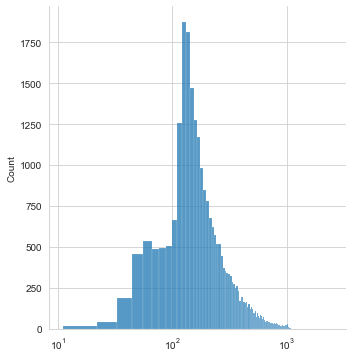

In [3]:
# Load Movie Reviews
vocab_size = 20000
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=42, skip_top=0, maxlen=None, oov_char=2,
                                                      index_from=3, num_words=vocab_size)
ax = sns.displot([len(review) for review in X_train])
ax.set(xscale='log');

In [4]:
# Prepare Data
maxlen = 100
X_train_padded = pad_sequences(X_train, truncating='pre', padding='pre', maxlen=maxlen)
X_test_padded = pad_sequences(X_test, truncating='pre', padding='pre', maxlen=maxlen)
X_train_padded.shape, X_test_padded.shape

((25000, 100), (25000, 100))

In [5]:
# Define Model Architecture
K.clear_session()

# Custom Loss Metric
embedding_size = 100

rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim= embedding_size, input_length=maxlen),
    GRU(units=32,  # units - # of output dimension
        recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,012,897
Trainable params: 2,012,897
Non-trainable params: 0
_________________________________________________________________


In [6]:
rnn.compile(loss='binary_crossentropy', optimizer='RMSProp',
            metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')])
rnn_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_AUC', mode='max',
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_AUC', mode='max', patience=5, restore_best_weights=True)

training = rnn.fit(X_train_padded, y_train, batch_size=32, epochs=100, validation_data=(X_test_padded, y_test),
                   callbacks=[early_stopping, checkpointer], verbose=1, workers=6)

Epoch 1/100
782/782 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.7939 - AUC: 0.8823
Epoch 00001: val_AUC improved from -inf to 0.92986, saving model to results/sentiment_imdb\lstm.h5
782/782 [==============================] - 282s 356ms/step - loss: 0.4300 - accuracy: 0.7939 - AUC: 0.8823 - val_loss: 0.5443 - val_accuracy: 0.7578 - val_AUC: 0.9299
Epoch 2/100
782/782 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8857 - AUC: 0.9513
Epoch 00002: val_AUC improved from 0.92986 to 0.93746, saving model to results/sentiment_imdb\lstm.h5
782/782 [==============================] - 281s 360ms/step - loss: 0.2821 - accuracy: 0.8857 - AUC: 0.9513 - val_loss: 0.3500 - val_accuracy: 0.8497 - val_AUC: 0.9375
Epoch 3/100
782/782 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9084 - AUC: 0.9669
Epoch 00003: val_AUC improved from 0.93746 to 0.93962, saving model to results/sentiment_imdb\lstm.h5
782/782 [=====================

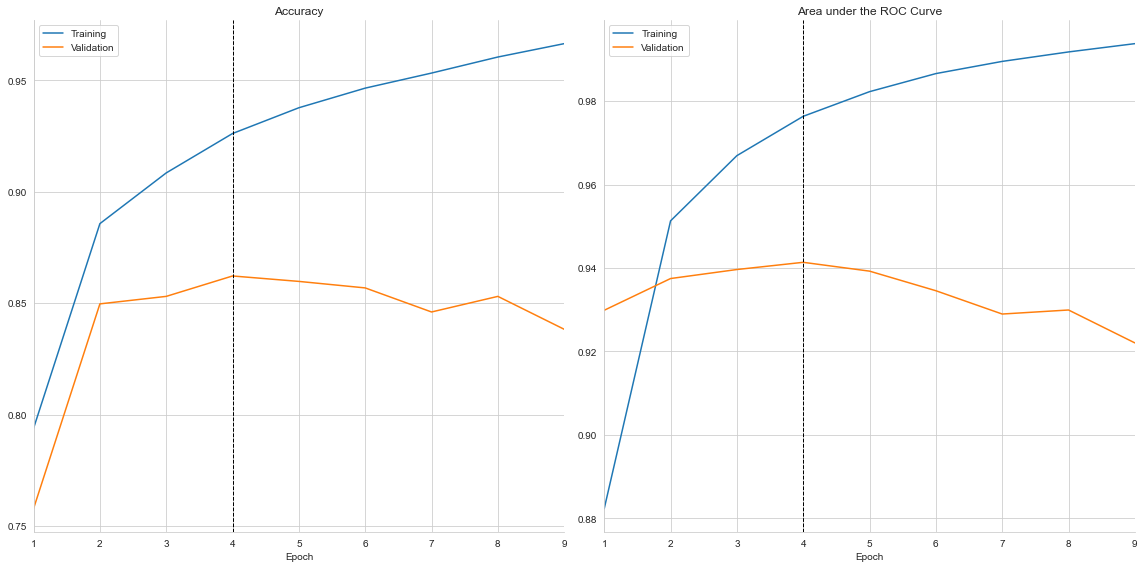

In [7]:
# Evaluate Results
history = pd.DataFrame(training.history)
history.index += 1
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
df1 = (history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Training',
                        'val_accuracy': 'Validation'}))
df1.plot(ax=axes[0], title='Accuracy', xlim=(1, len(history)))

axes[0].axvline(df1.Validation.idxmax(), ls='--', lw=1, c='k')

df2 = (history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Training', 'val_AUC': 'Validation'}))
df2.plot(ax=axes[1], title='Area under the ROC Curve', xlim=(1, len(history)))

axes[1].axvline(df2.Validation.idxmax(), ls='--', lw=1, c='k')

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_imdb_cv', dpi=300)

In [8]:
y_score = rnn.predict(X_test_padded)
y_score.shape

(25000, 1)

In [9]:
roc_auc_score(y_score=y_score.squeeze(), y_true=y_test)

0.9413989215999999